# Introduction

Can machine learning be used to Identify Fraud in Enron? Using emails and financial data released during the Federal investigation, we’ll attempt to identify executives that were persons of interest using machine learning. A person of interest (POI) is defined as a person who was indicted for fraud, settled with the government, or testified in exchange for immunity.

First, a brief background on Enron,before filing for bankruptcy in 2001, Enron Corporation was one of the largest integrated natural gas and electricity companies in the world. It marketed natural gas liquids worldwide and operated one of the largest natural gas transmission systems in the world, totaling more than 36,000 miles. It was also one of the largest independent developers and producers of electricity in the world, serving both industrial and emerging markets. Enron was also a major supplier of solar and wind renewable energy worldwide, managed the largest portfolio of natural gas-related risk management contracts in the world, and was one of the world's biggest independent oil and gas exploration companies. In North America, Enron was the largest wholesale marketer of natural gas and electricity. Enron pioneered innovative trading products, such as gas futures and weather futures, significantly modernizing the utilities industry. After a surge of growth in the early 1990s, the company ran into difficulties. The magnitude of Enron's losses was hidden from stockholders. The company folded after a failed merger deal with Dynegy Inc. in 2001 brought to light massive financial finagling. The company had ranked number seven on the Fortune 500, and its failure was the biggest bankruptcy in American history.

## Import Modules

In [90]:

%matplotlib inline
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
      return "{\centering %s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

## Determine Best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,f_regression

## Classifiers
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import MiniBatchKMeans


## Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

## Scalers
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer

## Component Reduction
from sklearn.lda import LDA
from sklearn.decomposition import PCA
from check import output_classifier

## Scoring
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics.scorer import make_scorer

## Split and validation
from sklearn.cross_validation import StratifiedShuffleSplit

## Search for best parameters for classifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

## Display pandas dataframe as HTML
from IPython.display import display


# Data Overview

## Import the data

Read the data and convert the data into pandas data frame. 

In [91]:

data_dict = pickle.load(open("final_project_dataset.pkl", "r") )
df = pd.DataFrame.from_dict(data_dict)
df = df.transpose()



## Review and Clean the Data

In [92]:
df.describe().transpose()

,count,unique,top,freq
bonus,146,42,NaN,64
deferral_payments,146,40,NaN,107
deferred_income,146,45,NaN,97
director_fees,146,18,NaN,129
email_address,146,112,NaN,35
exercised_stock_options,146,102,NaN,44
expenses,146,95,NaN,51
from_messages,146,65,NaN,60
from_poi_to_this_person,146,58,NaN,60
from_this_person_to_poi,146,42,NaN,60



A few things jump out, there appears to be 146 employees and the top value across all the fields is 'NaN'. A couple other items stand out, only a small number received loan_advances and paid direct fees. In addition, only 12% of the employees are person of interest. Based on the size and distribution of the dataset, stratified shuffle split to validate the precision and recall of the model.


In [93]:

df.email_address.head(5)
df[df['email_address'].str.contains("enron")==False].email_address.count() 


35


Email_address column is unquie like the employees name and doesn't provide additional value. In addition, all email addresses in the dataset contain enron or nan. Therefore, I choose to drop the email_address field. 


In [94]:

df.drop('email_address', 1,inplace=True)



Drop all employees with three or less features (3 including poi). This includes the Travel Agency and Lockhart.


In [95]:

df = df.replace('NaN', np.nan)
df=df.dropna(thresh=4,axis=0)



Describe provides concise overview of the dataset. The first item that jumps out... The top value in each column is 'NaN' which means the dataset contains a significant amount of missing data. 



Let's convert the remaining fields to numbers.


In [96]:

df = df.convert_objects(convert_numeric=True)
format = lambda x: "{0:.0f}".format(x)
df.describe().transpose().applymap(format)


,count,mean,std,min,25%,50%,75%,max
bonus,82,2374235,10713328,70000,431250,769375,1200000,97343619
deferral_payments,39,1642674,5161930,-102500,81573,227449,1002672,32083396
deferred_income,49,-1140475,4025406,-27992891,-694862,-159792,-38346,-833
director_fees,16,169774,330140,3285,83674,106164,112815,1398517
exercised_stock_options,99,6158405,31517823,3285,596344,1362375,2576926,311764000
expenses,95,108729,533535,148,22614,46950,79952,5235198
from_messages,86,609,1841,12,23,41,146,14368
from_poi_to_this_person,86,65,87,0,10,35,72,528
from_this_person_to_poi,86,41,100,0,1,8,25,609
loan_advances,4,41962500,47083209,400000,1600000,41762500,82125000,83925000


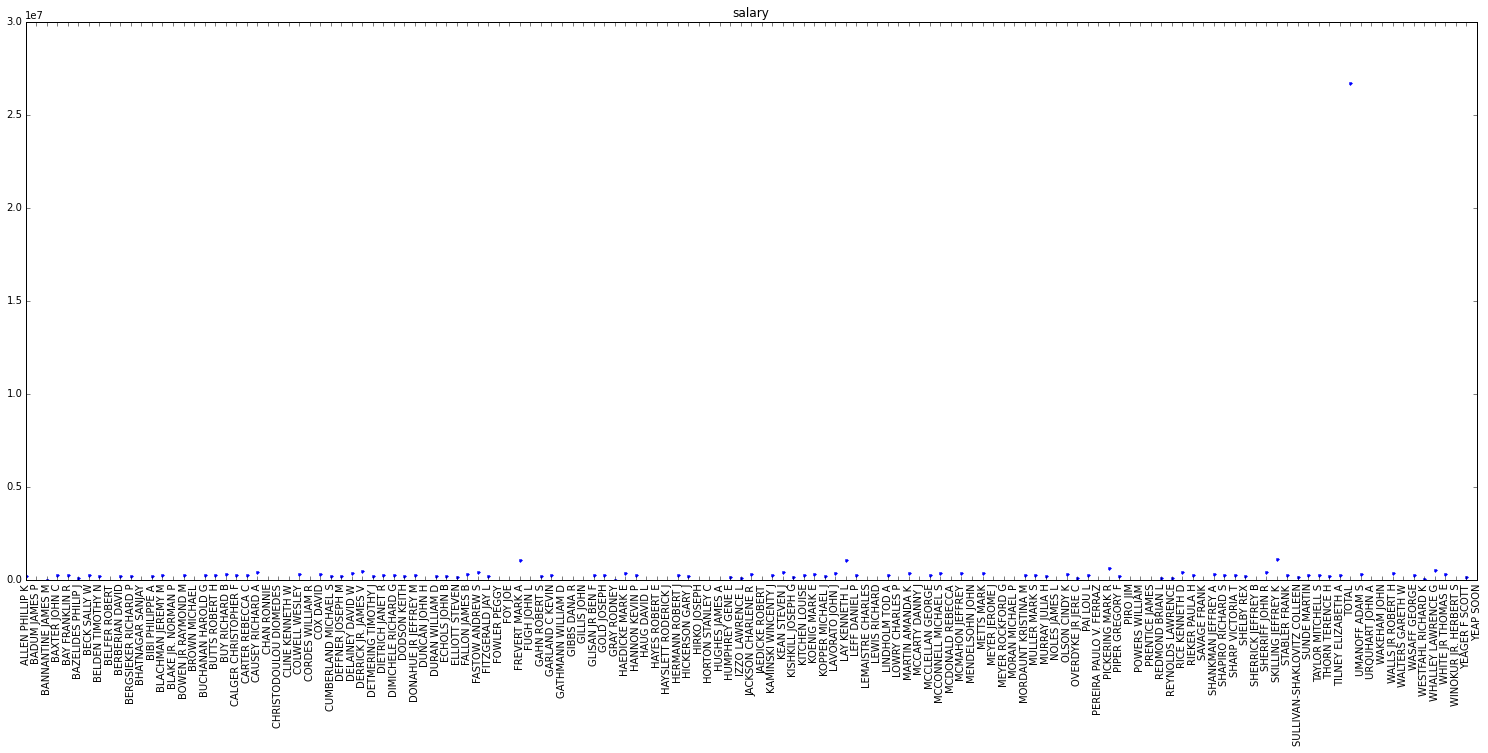

In [97]:

column='salary'

plt.figure(figsize=(26,10))
df[column].plot(style='.')
x = range(len(df[column]))
plt.xticks(x,df.index)
locs, labels = plt.xticks()

plt.setp(labels, rotation=90)
plt.title(column)
plt.show()



After plotting the employee salaries, it's clear the Total is an aggregate and it should be dropped as well.


In [98]:

df.drop('TOTAL', 0,inplace=True)


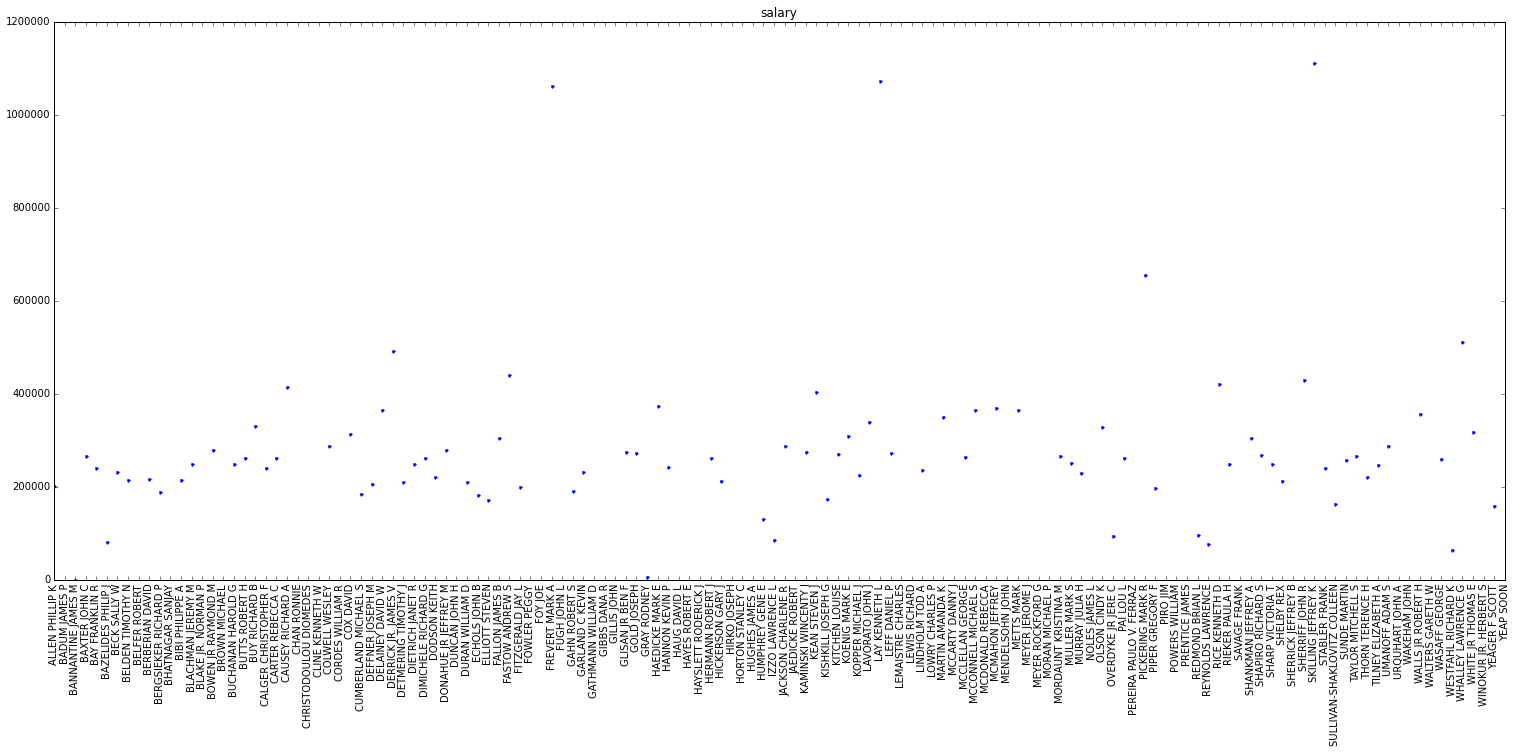

In [99]:

column='salary'

plt.figure(figsize=(26,10))
df[column].plot(style='.')
x = range(len(df[column]))
plt.xticks(x,df.index)
locs, labels = plt.xticks()

plt.setp(labels, rotation=90)
plt.title(column)
plt.show()



Now, we'll fill any NaNs with the mean.... I tried using Imputer but the model didn't perform as well. 


In [100]:

df = df.apply(lambda x: x.fillna(x.mean()),axis=0)



Next, we'll review the scatter plot for salary vs bonus, exercised_stock_options vs total_payments. Please see the final_project_plots.html to review all plots. 


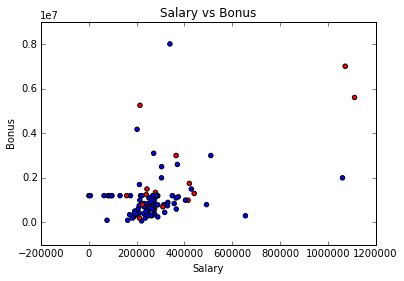

In [101]:

df.loc[df['poi'] == True, 'color'] = 'r'
df.loc[df['poi'] == False, 'color'] = 'b'
plt.scatter(x=df['salary'],y=df['bonus'],c=df['color'])
plt.title('Salary vs Bonus')
plt.xlabel('Salary')
plt.ylabel('Bonus')
plt.show()


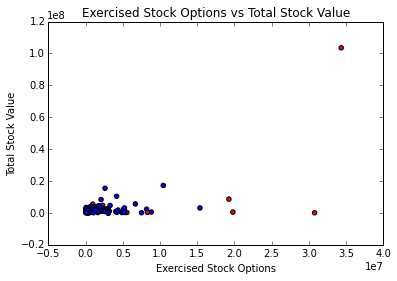

In [102]:

plt.scatter(x=df['exercised_stock_options'],y=df['total_payments'],c=df['color'])
plt.title('Exercised Stock Options vs Total Stock Value')
plt.xlabel('Exercised Stock Options')
plt.ylabel('Total Stock Value')
plt.show()


In [103]:

df.drop('color', axis=1, inplace=True)


## Create New Features and Create Feature List


First, I created a new feature to_poi_ratio. My belief is sending a high number emails to a POI likely means the person is also involved in fruad. Next, let's determine which feature should be included in the model.


In [104]:

df['to_poi_ratio'] = df['from_this_person_to_poi']/df['from_messages']

features_list = [
      'poi', 'bonus', 'deferral_payments', 'deferred_income'
    , 'director_fees', 'exercised_stock_options', 'expenses'
    , 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi'
    , 'loan_advances', 'long_term_incentive', 'other'
    , 'restricted_stock', 'restricted_stock_deferred', 'salary'
    , 'shared_receipt_with_poi', 'to_messages', 'total_payments'
    , 'total_stock_value', 'to_poi_ratio']

my_dataset = df.T.to_dict('dict')

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


## Select Best Features for Models

Linear_SVC Percent Recall/Precsiion for Features


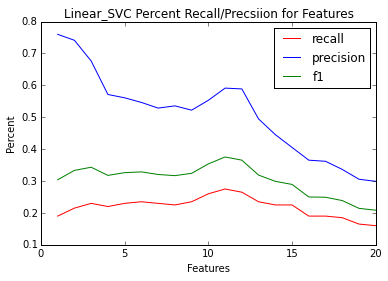

,accuracy,f1,f2,precision,recall
1,0.875714,0.304000,0.223529,0.760000,0.190
2,0.877143,0.333333,0.250583,0.741379,0.215
3,0.874286,0.343284,0.264977,0.676471,0.230
4,0.865000,0.317690,0.250855,0.571429,0.220
5,0.864286,0.326241,0.260771,0.560976,0.230
6,0.862857,0.328671,0.265237,0.546512,0.235
7,0.860714,0.320557,0.259301,0.528736,0.230
8,0.861429,0.316901,0.254525,0.535714,0.225
9,0.860000,0.324138,0.264045,0.522222,0.235
10,0.864286,0.353741,0.290828,0.553191,0.260


Naive_Bayes Percent Recall/Precsiion for Features


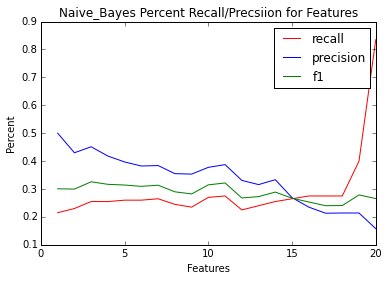

,accuracy,f1,f2,precision,recall
1,0.857143,0.300699,0.242664,0.500000,0.215
2,0.846429,0.299674,0.253583,0.429907,0.230
3,0.849286,0.325879,0.279299,0.451327,0.255
4,0.842857,0.316770,0.276573,0.418033,0.255
5,0.837857,0.314199,0.279270,0.396947,0.260
6,0.834286,0.309524,0.277778,0.382353,0.260
7,0.834286,0.313609,0.282516,0.384058,0.265
8,0.828571,0.289941,0.261194,0.355072,0.245
9,0.829286,0.282282,0.251876,0.353383,0.235
10,0.832143,0.314869,0.286320,0.377622,0.270


KNeighborsClassifier Percent Recall/Precsiion for Features


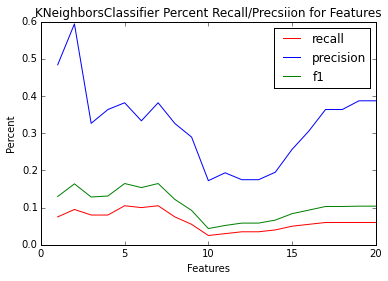

,accuracy,f1,f2,precision,recall
1,0.856429,0.129870,0.090253,0.483871,0.075
2,0.861429,0.163793,0.114183,0.593750,0.095
3,0.845000,0.128514,0.094229,0.326531,0.080
4,0.848571,0.131148,0.094787,0.363636,0.080
5,0.847857,0.164706,0.122807,0.381818,0.105
6,0.842857,0.153846,0.116279,0.333333,0.100
7,0.847857,0.164706,0.122807,0.381818,0.105
8,0.845714,0.121951,0.088652,0.326087,0.075
9,0.845714,0.092437,0.065632,0.289474,0.055
10,0.843571,0.043668,0.030157,0.172414,0.025


DecisionTreeClassifier Percent Recall/Precsiion for Features


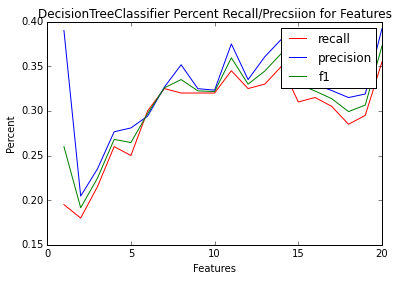

,accuracy,f1,f2,precision,recall
1,0.841429,0.260000,0.216667,0.390000,0.195
2,0.782857,0.191489,0.184426,0.204545,0.180
3,0.787857,0.224543,0.218718,0.234973,0.215
4,0.797143,0.268041,0.263158,0.276596,0.260
5,0.801429,0.264550,0.255624,0.280899,0.250
6,0.797143,0.297030,0.298805,0.294118,0.300
7,0.807857,0.325815,0.325325,0.326633,0.325
8,0.818571,0.335079,0.325866,0.351648,0.320
9,0.807857,0.322418,0.320963,0.324873,0.320
10,0.807143,0.321608,0.320641,0.323232,0.320


In [105]:

names = ["Linear_SVC","Naive_Bayes"
   ,"KNeighborsClassifier","DecisionTreeClassifier"]

classifiers = [LinearSVC(),GaussianNB()
   ,KNeighborsClassifier(n_neighbors=2),DecisionTreeClassifier()]

for name, classifier in zip(names, classifiers):

    print "{} Percent Recall/Precsiion for Features".format(name)
    results = {}
    for i in range(1,len(features_list)):

        clf = Pipeline([
           ('scaler', StandardScaler()),
           ('kbest', SelectKBest(k=i)),
           ('classifier', classifier),
        ])
        results[i] = output_classifier( clf, my_dataset, features_list, folds = 100)

    results = pd.DataFrame.from_dict(results).transpose()

    f_count = range(1,len(features_list))
    plt.plot(f_count, results.recall   , color='r', label='recall')
    plt.plot(f_count, results.precision, color='b', label='precision')
    plt.plot(f_count, results.f1       , color='g', label='f1')
    plt.xlabel('Features')
    plt.ylabel('Percent')
    plt.title( "{} Percent Recall/Precsiion for Features".format(name))
    plt.legend()
    

    
    plt.show()
    display(results)
    
    

    


Using selectkbest and the plots found in final_project_plots.html, I selected the following features for my initial model. 


In [106]:

features = StandardScaler().fit_transform(features)
selector = SelectKBest(k=5).fit(features, labels).scores_

for score, feature in sorted(zip(selector, features_list[1:]), reverse=True):
     print feature,score

        

exercised_stock_options 27.6300165058
total_stock_value 20.2386111807
to_poi_ratio 15.3323918413
bonus 11.0278729552
salary 9.06155550947
total_payments 7.3433576332
restricted_stock 6.60730691505
loan_advances 6.04841019442
long_term_incentive 5.74943809023
shared_receipt_with_poi 5.524340357
deferred_income 5.40792037439
from_poi_to_this_person 2.92653569833
other 1.80626877577
from_this_person_to_poi 1.31157326324
from_messages 0.564677533178
expenses 0.461224464842
deferral_payments 0.366498924661
to_messages 0.35488527817
director_fees 1.23951588535e-31
restricted_stock_deferred 3.94738593348e-32


## Create Final Feature List 

In [107]:

features_list = ['poi','exercised_stock_options' 
                ,'total_stock_value' ,'to_poi_ratio'
                ,'bonus','salary']

my_dataset = df.T.to_dict('dict')

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)



# Analysis Validation and Performance


Using an example for the sklearn documenation, I decided to test LinearSVC and GaussianNB using Principal Component Analysis (PCA) and . Principal Component Analysis (PCA) anad Linear Discriminant Analysis (LDA). PCA identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.


http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html



Based on the size and distribution of the dataset, Sklearn’s StratifiedShuffleSplit function was used to perform validation and capture performance measures. For 1000 folds, StratifiedShuffleSplit splits the dataset into two parts: training and testing sets. First, the training dataset is passed to the algorithm using fit. Then, the test dataset is passed to predict. Last, the results of predict is evaluated for each employee to determine if the outcome is a true positive, true negative, false positive, or false negative. After all 1000 folds are completed, the precision and recall is calculated.

In [108]:
dict_all = {}
dict_pca = {}
dict_lda = {}

## Run the models using StandardScaler

In [109]:

for name, clf in zip(names, classifiers):
    clf_all = Pipeline(steps=[
       ('scaler', StandardScaler()),
       ('classification', clf)
    ])
    dict_all[name] =  output_classifier(clf_all, my_dataset, features_list)
all = pd.DataFrame.from_dict(dict_all, orient='index')
all 


,recall,f1,f2,precision,accuracy
DecisionTreeClassifier,0.2395,0.240160,0.239764,0.240825,0.783500
KNeighborsClassifier,0.0795,0.121560,0.092270,0.258117,0.835857
Linear_SVC,0.2335,0.336334,0.266036,0.601030,0.868357
Naive_Bayes,0.3105,0.378197,0.334446,0.483645,0.854143


## Run the models using StandardScaler and PCA

In [110]:

for name, clf in zip(names, classifiers):
    clf_pca = Pipeline(steps=[
       ('scaler', StandardScaler()),
       ('reduce_dim', PCA(n_components=1)),
       ('classification', clf)
     ])
    dict_pca[name] =  output_classifier(clf_pca, my_dataset, features_list)
pca = pd.DataFrame.from_dict(dict_pca, orient='index')
pca


,recall,f1,f2,precision,accuracy
DecisionTreeClassifier,0.3565,0.356233,0.356393,0.355966,0.815929
KNeighborsClassifier,0.1700,0.258555,0.196987,0.539683,0.860714
Linear_SVC,0.2190,0.334479,0.254090,0.707593,0.875500
Naive_Bayes,0.2275,0.328283,0.259348,0.589378,0.867000


## Run the models using StandardScaler and LDA

In [111]:

for name, clf in zip(names, classifiers):
    clf_lda = Pipeline(steps=[
       #('scaler', StandardScaler()),
       ('reduce_dim', LDA(n_components=1)),
       ('classification', clf)
    ])
    dict_lda[name] =  output_classifier(clf_lda, my_dataset, features_list)
lda = pd.DataFrame.from_dict(dict_lda, orient='index')
lda


,recall,f1,f2,precision,accuracy
DecisionTreeClassifier,0.3415,0.358154,0.347972,0.376516,0.825143
KNeighborsClassifier,0.1835,0.273472,0.211308,0.536550,0.860714
Linear_SVC,0.2375,0.339893,0.270040,0.597484,0.868214
Naive_Bayes,0.3275,0.400857,0.353366,0.516562,0.860143



Using the features selected, I wasn't able build a model with recall and precision great than 30%. Next, I'll attempt to use performance tuning to build a model that meets the 30/30 goal. 


## Performance Tuning and Validation

John Meyers, in a stack overflow post, defined performance tuning as the following, In the abstract sense of machine learning, tuning is working with / "learning from" variable data based on some parameters which have been identified to affect system performance as evaluated by some appropriate1 metric. Improved performance reveals which parameter settings are more favorable (tuned) or less favorable (untuned). Translating this into common sense, tuning is essentially selecting the best parameters for an algorithm to optimize its performance given a working environment such as hardware, specific workloads, etc. And tuning in machine learning is an automated process for doing this.

To put performance tuning into even simpler terms, Performance tuning in machine learning is similar to performance tuning your car. In car, you might put in new spark plugs, brake pads, exhaust system, or computer chip to make the car accelerate or stop more quickly. In machine learning, performance tuning is the ability to increase the performance, in this case precise and recall, without additional data. 


Cross-validation definition from Wikipedia:
Cross-validation, sometimes called rotation estimation,is a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. In a prediction problem, a model is usually given a dataset of known data on which training is run (training dataset), and a dataset of unknown data (or first seen data) against which the model is tested (testing dataset). The goal of cross validation is to define a dataset to "test" the model in the training phase (i.e., the validation dataset), in order to limit problems like overfitting, give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem), etc.

One round of cross-validation involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (called the training set), and validating the analysis on the other subset (called the validation set or testing set). To reduce variability, multiple rounds of cross-validation are performed using different partitions, and the validation results are averaged over the rounds.

Cross-validation is important in guarding against testing hypotheses suggested by the data, especially where further samples are hazardous, costly or impossible to collect.

Furthermore, one of the main reasons for using cross-validation instead of using the conventional validation (e.g. partitioning the data set into two sets of 70% for training and 30% for test) is that the error (e.g. Root Mean Square Error) on the training set in the conventional validation is not a useful estimator of model performance and thus the error on the test data set does not properly represent the assessment of model performance. This may be because there is not enough data available or there is not a good distribution and spread of data to partition it into separate training and test sets in the conventional validation method. In these cases, a fair way to properly estimate model prediction performance is to use cross-validation as a powerful general technique.

In summary, cross-validation combines (averages) measures of fit (prediction error) to correct for the optimistic nature of training error and derive a more accurate estimate of model prediction performance.


Simply put, Cross-validation is model validation technique used to determine how well the statistical analysis perform on an independent dataset and is used to prevent over-fitting. 

In [112]:

## define a scoring function to return f1 only
## if precision and recall greater than 30%
def score_func(y_true, y_pred, **kwargs):
    r = recall_score(y_true, y_pred, **kwargs)
    p = precision_score(y_true, y_pred, **kwargs)
    if r > 0.30 and p > 0.30:
       return f1_score(y_true, y_pred, **kwargs)
    else:
       return 0

scorer  = make_scorer(score_func)


## GridSearch CV

In [ ]:

clf = Pipeline([
    #('scaler', StandardScaler()),
    #('kbest', SelectKBest()),
    ('lda', LDA()),
    ('classifier', GaussianNB())
])

parameters = {
    #'kbest__score_func'         : (f_classif, f_regression),
    #'kbest__k'                  : range(1,len(features_list)),
    'lda__n_components'         : range(1,4),
    'lda__store_covariance'     : (True, False),
    'lda__solver'               : ('svd','eigen')
}

cv = StratifiedShuffleSplit(labels,n_iter=200,test_size=.30)
gs = GridSearchCV(clf,parameters,n_jobs=-1,cv=cv,scoring=scorer)
gs.fit(features, labels)
clf = gs.best_estimator_


## Final Output from Tune Classifier

In [114]:

clf = Pipeline(
    steps=[
       #('scaler', StandardScaler()),
       #('kbest', SelectKBest(k=5, score_func=f_classif)),
       ('lda', LDA(n_components=1, priors=None
                ,shrinkage=None, solver='svd'
                , store_covariance=False, tol=0.0001)),
       #('kmeans', MiniBatchKMeans(n_clusters=20, n_init=10
       #                           , max_no_improvement=10, verbose=0)),
       ('classifier', GaussianNB())
    ])

output = test_classifier(clf, my_dataset, features_list,folds=1000)
dump_classifier_and_data(clf, my_dataset, features_list)


Pipeline(steps=[('lda', LDA(n_components=1, priors=None, shrinkage=None, solver='svd',
  store_covariance=False, tol=0.0001)), ('classifier', GaussianNB())])

Accuracy: 0.86014
Precision: 0.51656
Recall: 0.32750
F1: 0.40086
F2: 0.35337

Total predictions: 14000                         
True positives:  655                         
False positives:  613                         
False negatives: 1345                         
True negatives: 11387



# Discussion and Conclusions

Recall and precision measure the quality of your result. The algorithm results are one of the following:
	

Classified Correctly      |  Description                           
--------------------------|--------------------------------------
true positive (TP)        |  a POI predicted as a POI             
true negative (TN)        |  a non-POI predicted as a non-POI      

Classified Incorrectly    |  Description
--------------------------|--------------------------------------
false positive (FP)       | a non-POI which is predicted as a POI
false negative (FN)       | a POI which is predicted as a non-POI

Formula Name              |  Formula                                     
--------------------------|--------------------------------------
precision 	              | TP/TP+FP                              
recall 		              | TP/TP+FN                             

The precision can be interpreted as the likelihood that a person who is identified as a POI is actually a true POI. Based on the final model, this means 50% POI are correctly identified and 50% would be incorrect. Unfortunately, the recall on this model is 31%. This means 78% of the time POI's would not be caught. 

So, Can machine learning be used to Identify Fraud in Enron? Based on my findings, yes. With additional time, a better understanding of the dataset, and a few additional data points, the performance still could be improved.  

# References



    http://www.referenceforbusiness.com/history2/57/Enron-Corporation.html

    https://docs.google.com/document/d/1wCkOFWtGqOV7ira09NoZA7Otuf8SoUG2GuJUWmFbaQk/pub

    http://harshtechtalk.com/model-hyperparameter-tuning-scikit-learn-using-gridsearch/

    http://www.dataschool.io/machine-learning-with-scikit-learn/

    http://scikit-learn.org

    https://github.com/ipython-contrib/IPython-notebook-extensions/wiki/Comment-uncomment

    https://medium.com/seek-product-management/8-out-of-10-brown-cats-6e39a22b65dc

    http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

    https://en.wikipedia.org/wiki/Cross-validation_(statistics)